In [32]:
import pandas as pd
import numpy as np
import random
import torch
import glob
import pylab as plt
import torch.nn as nn
import math
import requests
import json
import torchvision.transforms as T
import os

import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from torchvision import datasets, transforms
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
import tensorflow
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [33]:
img_height = 64
img_width = 64
number_species_interested=20 #Change this if you want top ## species
df_IDs_imgnum = pd.read_csv('/kaggle/input/ids-species/IDs_imgnum_genus_species.csv')
num_epochs=10

In [34]:
#df_IDs_imgnum = pd.read_csv('./IDs_imgnum_genus_species.csv') #To be used when run locally
df_IDs_imgnum_sorted=df_IDs_imgnum.sort_values(by="Image Numbers",ascending=False).reset_index()
top_imgcount_species=df_IDs_imgnum_sorted.head(number_species_interested)
top_imgcount_species_list=top_imgcount_species['IDs'].values.tolist()
print(top_imgcount_species)

    index      IDs  Image Numbers         genus                  species
0     235  9364935            888   Notiophilus   Notiophilus biguttatus
1      52  1035931            861     Bembidion     Bembidion tetracolum
2      42  7508714            818  Pterostichus    Pterostichus strenuus
3      87  4475140            719       Ophonus       Ophonus rufibarbis
4      22  1036216            686     Bembidion        Bembidion lampros
5     205  5755079            651        Agonum       Agonum fuliginosum
6     155  4474169            642     Paranchus        Paranchus albipes
7     128  1035185            599         Amara              Amara aenea
8     207  1035195            570         Amara         Amara familiaris
9      96  1035864            566      Harpalus        Harpalus serripes
10    262  4475677            553     Acupalpus         Acupalpus dubius
11    151  1036154            535     Bembidion        Bembidion guttula
12    159  5754974            520    Anchomenus    

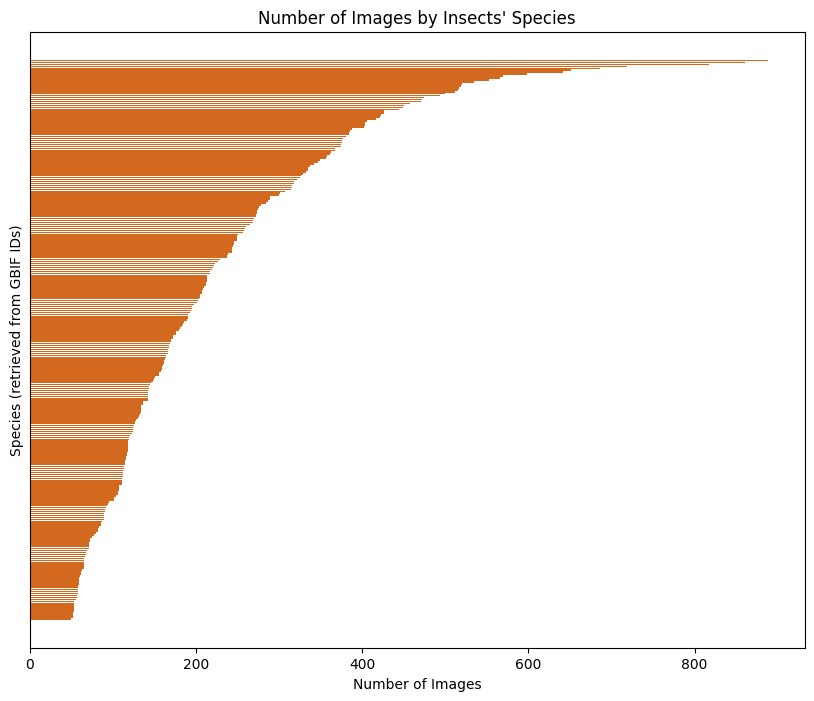

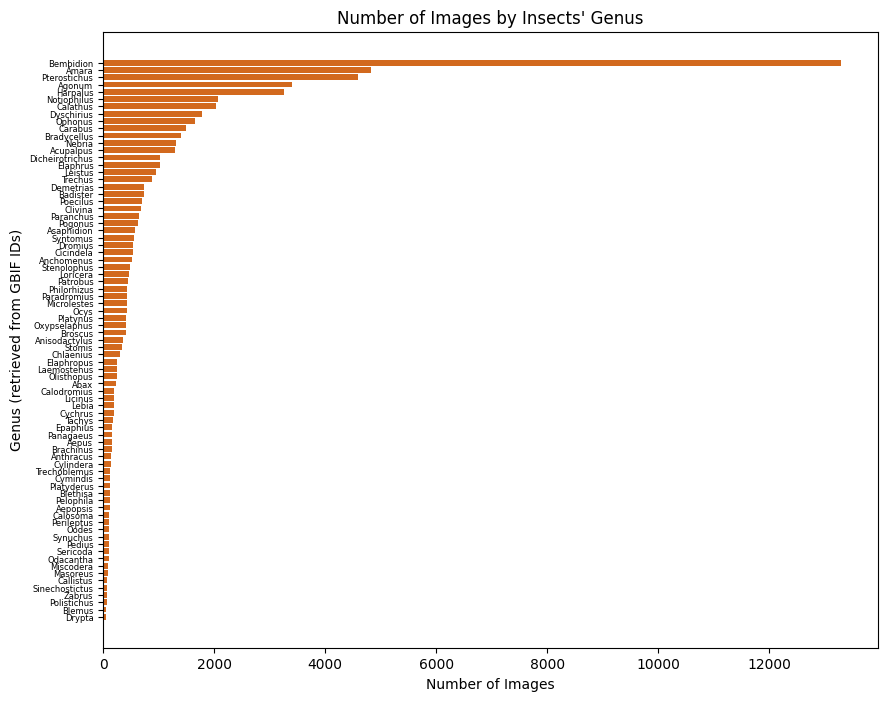

/tmp/ipykernel_33/438381974.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_spectrum = plt.cm.get_cmap('tab20b')


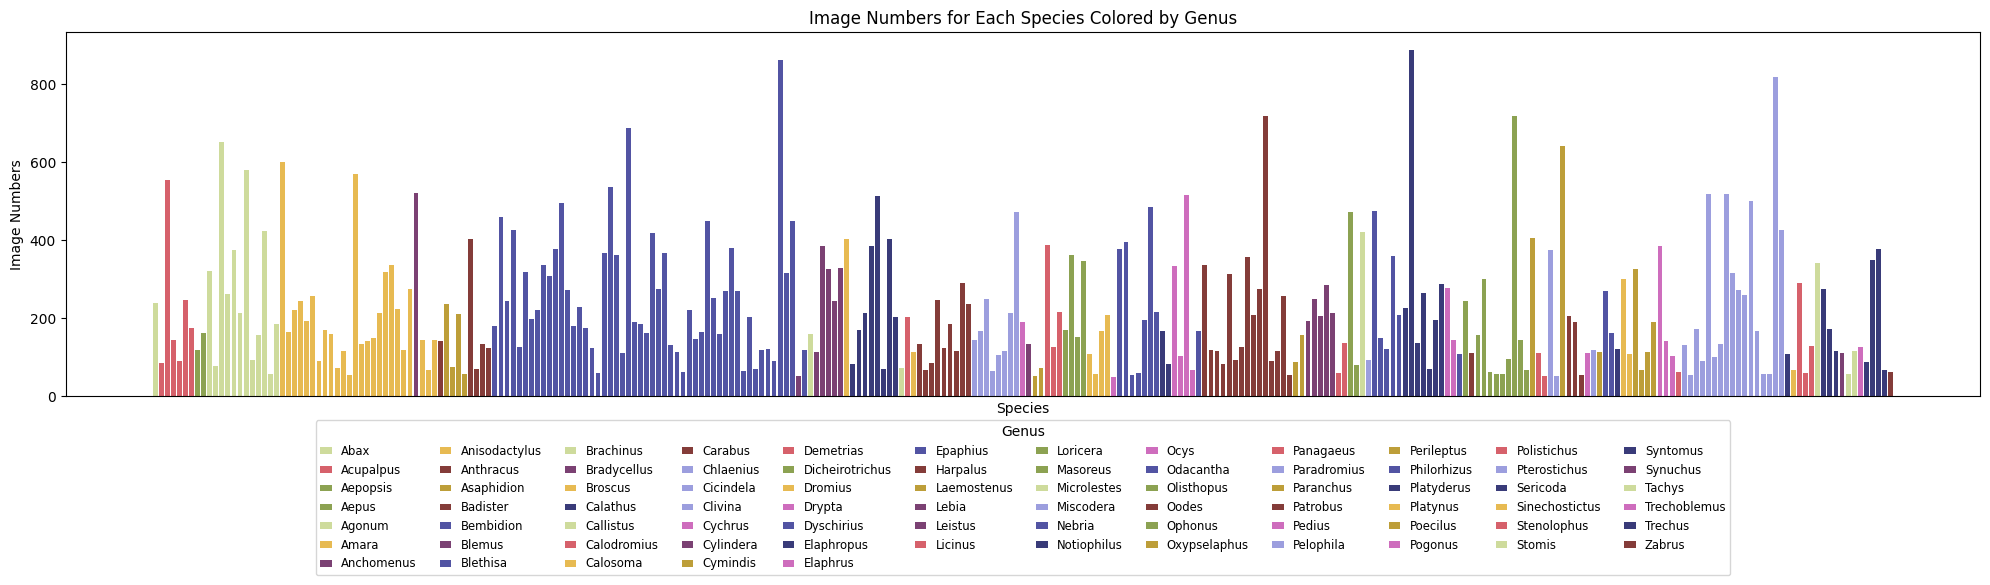

In [35]:
df_sorted_imgnum = df_IDs_imgnum_sorted.sort_values(by='Image Numbers', ascending=False)

# Plot 1: Species and Image Numbers
plt.figure(figsize=(10, 8))
plt.barh(df_sorted_imgnum['species'], df_sorted_imgnum['Image Numbers'],color='chocolate')
plt.xlabel('Number of Images')
plt.ylabel('Species (retrieved from GBIF IDs)')
plt.title('''Number of Images by Insects' Species''')
plt.yticks([])  # Remove y-axis tick marks
plt.gca().invert_yaxis()  # Invert y-axis to have the species with the most images at the top
plt.show()

# Plot 2: Genus and Image Numbers
df_grouped_genus = df_IDs_imgnum_sorted.groupby('genus')['Image Numbers'].sum().reset_index().sort_values(by='Image Numbers', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(df_grouped_genus['genus'], df_grouped_genus['Image Numbers'],color='chocolate')
plt.xlabel('Number of Images')
plt.ylabel('Genus (retrieved from GBIF IDs)')
plt.title('''Number of Images by Insects' Genus''')
plt.yticks(fontsize=6)  # Adjust the font size of y-axis tick marks (change the value as needed)
plt.gca().invert_yaxis()  # Invert y-axis to have the genus with the most images at the top
plt.show()


#Plot 3: Species and Image Numbers, colored by Genus
grouped_by_genus_species = df_IDs_imgnum_sorted.groupby(['genus', 'species'])
# Label every genus with a color
species_imgnum_sum = grouped_by_genus_species['Image Numbers'].sum().reset_index()
unique_genus = df_IDs_imgnum_sorted['genus'].unique()
num_colors = len(unique_genus)//7
color_spectrum = plt.cm.get_cmap('tab20b')
colors = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors2 = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors3 = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors4 = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors5 = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors6 = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors7 = [color_spectrum(i / num_colors) for i in range(num_colors)]
colors=colors+colors2+colors3+colors4+colors5+colors6+colors7
genus_color_map = dict(zip(unique_genus, colors))
species_imgnum_sum['color'] = species_imgnum_sum['genus'].map(genus_color_map)
#Plot the bar graph
encountered_genus = set()
plt.figure(figsize=(20, 6))
# Iterate through species
for i, row in species_imgnum_sum.iterrows():
    genus = row['genus']
    species = row['species']
    image_numbers = row['Image Numbers']
    if genus not in encountered_genus:
        plt.bar(species, image_numbers, color=genus_color_map[genus], label=genus)
        encountered_genus.add(genus)
    else:
        plt.bar(species, image_numbers, color=genus_color_map[genus])
plt.legend(title='Genus', loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, fontsize='small', ncol=len(unique_genus)//6, handlelength=1, handleheight=0.5)
plt.xticks([])
plt.xlabel('Species')
plt.ylabel('Image Numbers')
plt.title('Image Numbers for Each Species Colored by Genus')
plt.tight_layout()
plt.show()


/tmp/ipykernel_33/2084140407.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_spectrum = plt.cm.get_cmap('tab20b')
/tmp/ipykernel_33/2084140407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_imgcount_species['color'] = top_imgcount_species['genus'].map(genus_color_map)


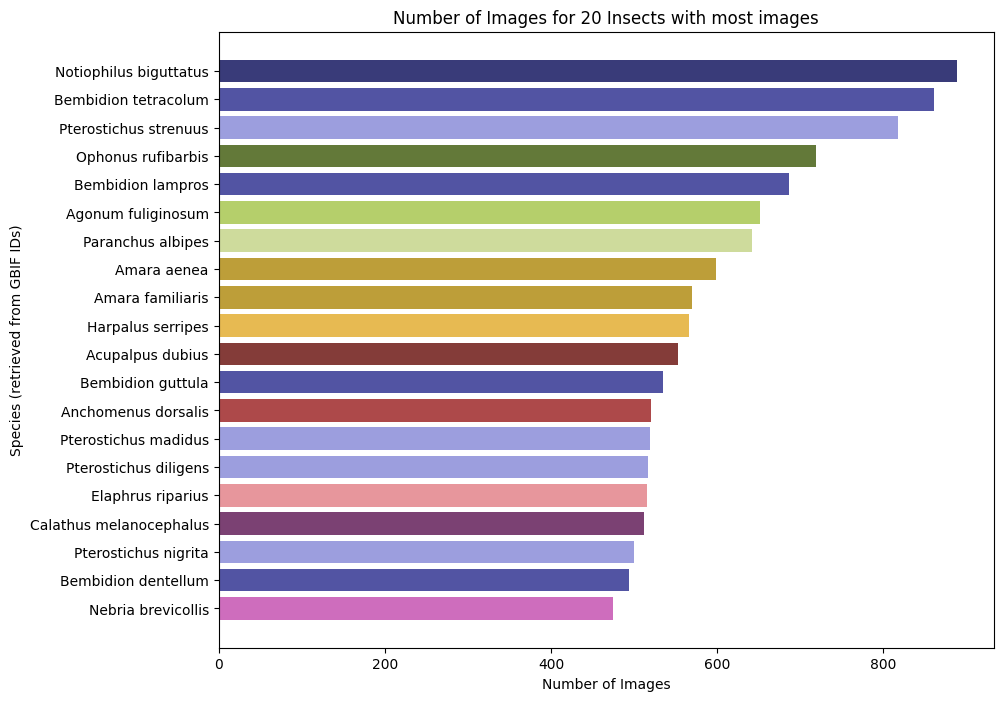

In [36]:
#Plot 4: Top Species and Image Numbers, colored by Genus
unique_genus = top_imgcount_species['genus'].unique()
#Label every genus with a color
color_spectrum = plt.cm.get_cmap('tab20b')
num_colors = len(unique_genus)
colors = [color_spectrum(i / num_colors) for i in range(num_colors)]
genus_color_map = dict(zip(unique_genus, colors))
top_imgcount_species['color'] = top_imgcount_species['genus'].map(genus_color_map)
# Plot the bar graph
encountered_genus = set()
plt.figure(figsize=(10, 8))
# Iterate through species
for i, row in top_imgcount_species.iterrows():
    genus = row['genus']
    species = row['species']
    image_numbers = row['Image Numbers']
    if genus not in encountered_genus:
        plt.barh(species, image_numbers, color=genus_color_map[genus], label=genus)
        encountered_genus.add(genus)
    else:
        plt.barh(species, image_numbers, color=genus_color_map[genus])
df_sorted_imgnum = top_imgcount_species.sort_values(by='Image Numbers', ascending=False)
plt.xlabel('Number of Images')
plt.ylabel('Species (retrieved from GBIF IDs)')
plt.title('''Number of Images for 20 Insects with most images''')
plt.gca().invert_yaxis()  
plt.show()

In [37]:
images = []
labels_species = [] #unecessarybutmightbehelpful
labels_genus = [] #unecessarybutmightbehelpful
labels=[]
labels_imgnum=[]
data_path = "/kaggle/input/insect-identification-from-habitus-images/database/"
exhaust_ID_list = os.listdir(data_path)
class_to_index = {cls: i for i, cls in enumerate(exhaust_ID_list)}
for id in exhaust_ID_list:
    if float(id) in top_imgcount_species_list: 
        id_folder = os.path.join(data_path, id)
        for img_file in os.listdir(id_folder):
            img_path = os.path.join(id_folder, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_height, img_width))  # Resize images as needed
            # img = preprocess_input(img)
            images.append(img)
            labels.append(class_to_index[id])
        labels_imgnum.append(top_imgcount_species[top_imgcount_species['IDs'] == float(id)]['Image Numbers'].iloc[0])
        labels_species.append(top_imgcount_species[top_imgcount_species['IDs'] == float(id)]['species'].iloc[0])
        labels_genus.append(top_imgcount_species[top_imgcount_species['IDs'] == float(id)]['genus'].iloc[0])
            


images = np.array(images)
labels=np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

In [38]:
# UNCOMMENT FOR DATA AUGMENTATION

# data_augmentation = ImageDataGenerator(
#     rotation_range=0,      # Randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.01,  # Randomly horizontally shift images
#     height_shift_range=0.01, # Randomly vertically shift images
#     shear_range=0.01,        # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#     zoom_range=0.01,         # Randomly zoom image 
#     horizontal_flip=True,   # Randomly flip images horizontally
#     fill_mode='nearest'     # Strategy used for filling in newly created pixels
# )

# train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

# train_generator = data_augmentation.flow_from_directory(
#     '/kaggle/input/insect-identification-from-habitus-images/database/',  # Path to the directory of training images
#     target_size=(64, 64),  # The dimensions to which all images will be resized
#     batch_size=32,
#     class_mode='categorical'  # Use 'categorical' for multi-class classification
# )

In [39]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To log the number of epochs after which training was stopped
    restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss
)
model_checkpoint = ModelCheckpoint(
    'bug_model1.keras',        # Path where to save the model
    monitor='val_accuracy', # Metric to monitor
    save_best_only=True,    # Only save a model if `val_accuracy` has improved
    verbose=0              # Log when a new best model is saved
)

In [40]:
num_classes = number_species_interested 

model_base = Sequential()
model_base.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_base.add(BatchNormalization()) # BN added
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Conv2D(64, (3, 3), activation='relu'))
model_base.add(BatchNormalization())  # BN added
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Flatten())
model_base.add(Dense(64, activation='relu'))
model_base.add(Dense(len(exhaust_ID_list), activation='softmax'))


model_base.compile(Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model_base.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [41]:
base_mobilenetV2 = tensorflow.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='/kaggle/input/mobilenet/mobilenet_weights.weights.h5',
    pooling='max'
)


#Freeze Base Model Layers, Leave Top 10 Unfrozen 
for layer in base_mobilenetV2.layers[10:]:
    layer.trainable = False
x = Flatten()(base_mobilenetV2.output)
x = Dense(64, activation='relu')(x)

predictions = Dense(len(exhaust_ID_list), activation='softmax')(x)
model_tl = Model(inputs=base_mobilenetV2.input, outputs=predictions)

model_tl.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_tl.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,358,883 (9.00 MB)

 Trainable params: 104,259 (407.26 KB)

 Non-trainable params: 2,254,624 (8.60 MB)

In [42]:
model_training="base"
metrics_list = []

print("Training",model_training,"with",number_species_interested,"species through",num_epochs,"epochs")
for epoch in range(num_epochs):
    print("\033[1mTraining Epoch",epoch+1,"\033[0m")
    history = model_base.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping,model_checkpoint],verbose=1 )
    
    # Extract metrics from the history object
    accuracy = history.history['accuracy'][0]
    loss = history.history['loss'][0]
    val_accuracy = history.history['val_accuracy'][0]
    val_loss = history.history['val_loss'][0]
    
    # Append the metrics as a dictionary to the list
    metrics_list.append({'Epoch': epoch + 1,
                         'Accuracy': accuracy,
                         'Loss': loss,
                         'Val_Accuracy': val_accuracy,
                         'Val_Loss': val_loss})

    # Evaluate the model on the test dataset after each epoch
    loss_test, accuracy_test = model_base.evaluate(X_test, y_test)
    print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(model_training+"_"+str(number_species_interested)+"species_"+str(num_epochs)+"epoch"'.csv', index=False)

Training base with 20 species through 10 epochs
Training Epoch 1 
228/228 ━━━━━━━━━━━━━━━━━━━━ 34s 140ms/step - accuracy: 0.1790 - loss: 3.9069 - val_accuracy: 0.3564 - val_loss: 2.0878
Restoring model weights from the end of the best epoch: 1.
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3640 - loss: 2.0838
Test Loss: 2.08777117729187, Test Accuracy: 0.35639283061027527
Training Epoch 2 
228/228 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - accuracy: 0.5111 - loss: 1.6016 - val_accuracy: 0.4750 - val_loss: 1.7186
Restoring model weights from the end of the best epoch: 1.
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4798 - loss: 1.7167
Test Loss: 1.7186402082443237, Test Accuracy: 0.4749845564365387
Training Epoch 3 
228/228 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.6951 - loss: 1.0706 - val_accuracy: 0.5551 - val_loss: 1.4801
Restoring model weights from the end of the best epoch: 1.
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5527 - loss: 1.5012
Test

In [47]:
model_training="base_transferlearning"
metrics_list = []

print("Training",model_training,"with",number_species_interested,"species through",num_epochs,"epochs")
for epoch in range(num_epochs):
    print("\033[1mTraining Epoch",epoch+1,"\033[0m")
    history = model_tl.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping,model_checkpoint],verbose=1 )
    
    # Extract metrics from the history object
    accuracy = history.history['accuracy'][0]
    loss = history.history['loss'][0]
    val_accuracy = history.history['val_accuracy'][0]
    val_loss = history.history['val_loss'][0]
    
    # Append the metrics as a dictionary to the list
    metrics_list.append({'Epoch': epoch + 1,
                         'Accuracy': accuracy,
                         'Loss': loss,
                         'Val_Accuracy': val_accuracy,
                         'Val_Loss': val_loss})

    # Evaluate the model on the test dataset after each epoch
    loss_test, accuracy_test = model_tl.evaluate(X_test, y_test)
    print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(model_training+"_"+str(number_species_interested)+"species_"+str(num_epochs)+"epoch"'.csv', index=False)

Training base_transferlearning with 20 species through 10 epochs
Training Epoch 1 
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 189ms/step - accuracy: 0.8830 - loss: 0.3312 - val_accuracy: 0.5923 - val_loss: 1.5335
Restoring model weights from the end of the best epoch: 1.
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5966 - loss: 1.5242
Test Loss: 1.5335100889205933, Test Accuracy: 0.5923409461975098
Training Epoch 2 
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 189ms/step - accuracy: 0.9072 - loss: 0.2899 - val_accuracy: 0.6168 - val_loss: 1.3639
Restoring model weights from the end of the best epoch: 1.
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6189 - loss: 1.3520
Test Loss: 1.3639042377471924, Test Accuracy: 0.6168416738510132
Training Epoch 3 
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 189ms/step - accuracy: 0.9082 - loss: 0.2746 - val_accuracy: 0.6533 - val_loss: 1.2268
Restoring model weights from the end of the best epoch: 1.
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6668 -

152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


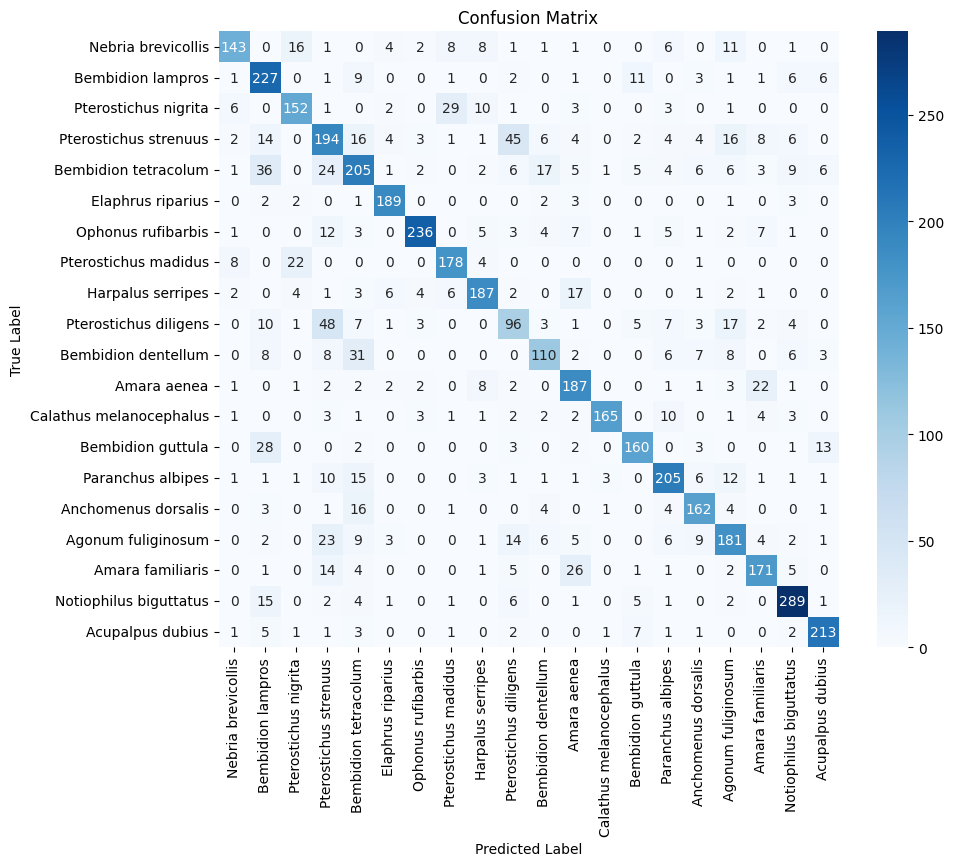

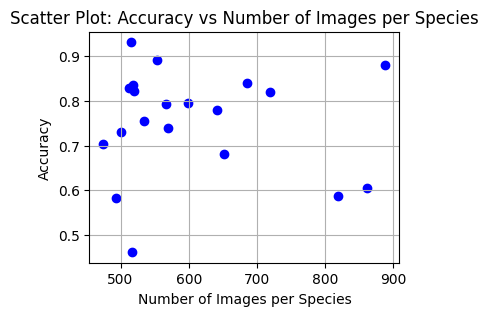

In [48]:
# Compute the confusion matrix
predictions_prob = model_base.predict(X_test)
y_pred = np.argmax(predictions_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels_species, yticklabels=labels_species)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



plt.figure(figsize=(4, 3))
plt.scatter(labels_imgnum, per_class_accuracy, color='blue')
plt.title('Scatter Plot: Accuracy vs Number of Images per Species')
plt.xlabel('Number of Images per Species')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step


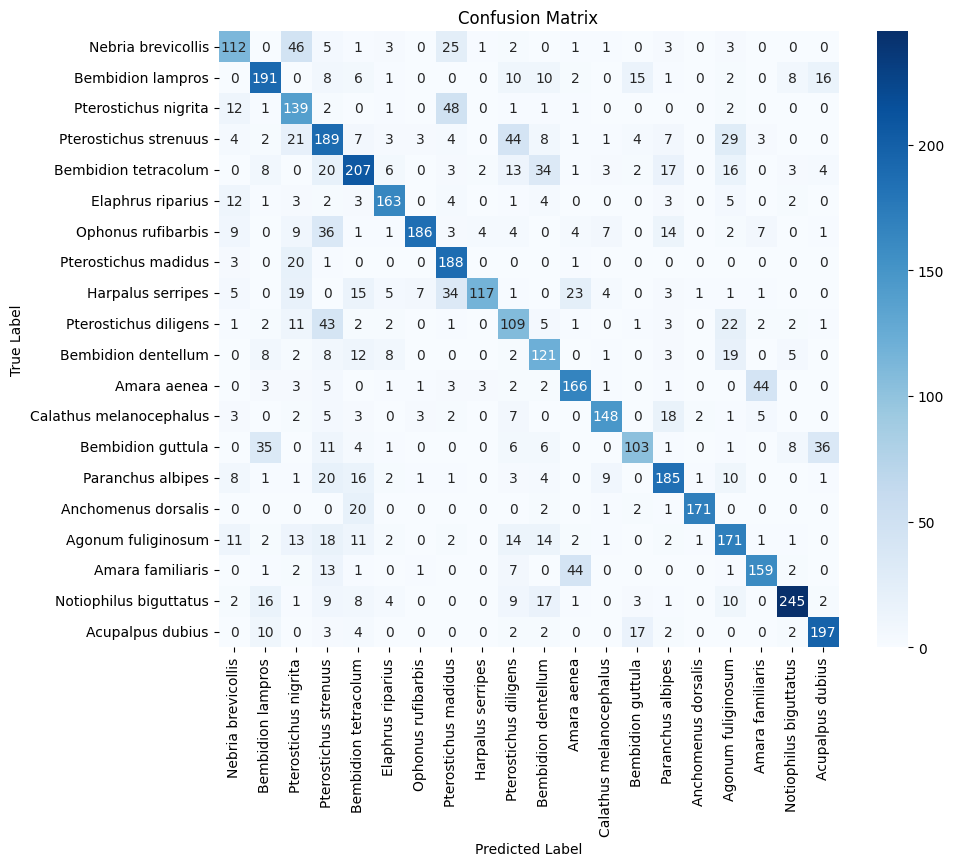

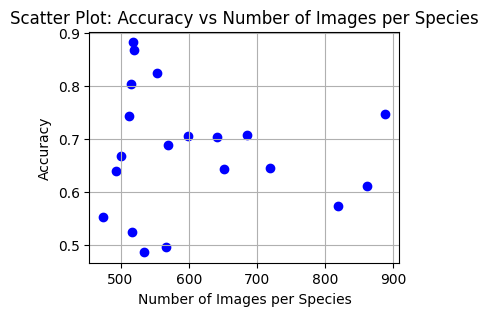

In [49]:
# Compute the confusion matrix
predictions_prob = model_tl.predict(X_test)
y_pred = np.argmax(predictions_prob, axis=1)
cmtl = confusion_matrix(y_test, y_pred)

# Calculate per-class accuracy
per_class_accuracytl = cmtl.diagonal() / cmtl.sum(axis=1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmtl, annot=True, cmap='Blues', fmt='g', xticklabels=labels_species, yticklabels=labels_species)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



plt.figure(figsize=(4, 3))
plt.scatter(labels_imgnum, per_class_accuracytl, color='blue')
plt.title('Scatter Plot: Accuracy vs Number of Images per Species')
plt.xlabel('Number of Images per Species')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()